<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Spatial_interpolation/kriging_As_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kriging Groundwater As in R**

Zia Ahmed, Unversity Buffalo

### Install rpy2

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314932 sha256=767023a21e032a0be94e38600dc659602ba1ab5ad9a7ddf731ec5200f85a3f73
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Check and Install Required R Packages

In [ ]:
%%R
pkg <- c('tidyverse', 'tidymodels', 'raster', 'rgdal','terra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'rasterVis', 'gridExtra', 'data.table', 'gstat','Hmisc','corrplot',
         'ggpmisc', 'spatstat', 'moments', 'car')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [ ]:
%%R
install.packages('sysfonts', lib='drive/My Drive/R/')
install.packages('showtext', lib='drive/My Drive/R/')

In [ ]:
%%R
install.packages('triebeard',  lib='drive/My Drive/R/')

In [ ]:
!sudo apt-get -y install r-cran-gdtools '/drive/My Drive/R/'

In [ ]:
%%R
install.packages('dlookr', lib='drive/My Drive/R/')

In [ ]:
%%R
install.packages('flextable', lib='drive/My Drive/R/')

### Load R Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library(dlookr)
library (tidyverse)
library(tidymodels)
library(sf)
library(terra)
library(raster)
library(RColorBrewer)
library(rasterVis)
library(RStoolbox)
library(gridExtra)
library(latticeExtra)
library(data.table)
library(gstat)
library(classInt)
library(car)
library(ggpmisc)
#library(dlookr)
library(flextable)

### Data

In this exercise will use ground water arsenic (As) concentration data for Bangladesh from British Geological Survey. The data-base contains hydro-chemical data of the survey of 3534 boreholes from 61 of the 64 districts of Bangladesh. About 27.7% and 2.5% of the sampled wells had As concentration less than the instrumental detection limit of 0.5 u/L for hydride generation-atomic fluorescence spectrometry and 6.0 ug/L for hydride generation- ICP- AES, respectively. Samples that have As concretion below detection limits, we assigned values of half the equipment detection limits (0.25 or 3.0 ug/l).

The following data will be used in the exercise that can be found in my [Dropbox](https://www.dropbox.com/scl/fo/j7322sbo4gdqv8a2rfqry/h?rlkey=fmlnsu08lut4pxf0s4q1jm44a&dl=0) folder.

1. bgs_geochemical.csv
2. BD_Banladesh_BUTM.shp

In [ ]:
%%R
df<-read_csv('/content/drive/MyDrive/R_Website/Spatial_Interpolation/Data/bgs_geochemical.csv')
bd<-shapefile('/content/drive/MyDrive/R_Website/Spatial_Interpolation/Data/BD_Banladesh_BUTM.shp')

Rows: 3534 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (23): SAMPLE_ID, SAMPLE_FIELD_ID, SAMPLE_DATE, WELL_TYPE, DIVISION, DIST...
dbl (11): LONG_DEG, LAT_DEG, YEAR_CONSTRUCTION, WELL_DEPTH, GEOCODE, As, Ca,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


###  Explotory data analysis

In [ ]:
%%R
glimpse(df)

Rows: 3,534
Columns: 34
$ SAMPLE_ID         <chr> "S98_02701", "S98_02715", "S98_02979", "S98_02992", …
$ SAMPLE_FIELD_ID   <chr> "RIP1640", "RIP2184", "RIP0490", "RIP0506", "RIP1056…
$ SAMPLE_DATE       <chr> "9/5/1998", "16/04/1998", "2/6/1998", "4/6/1998", "2…
$ LONG_DEG          <dbl> 90.0930, 89.4100, 91.6030, 91.1750, 89.5550, 89.4020…
$ LAT_DEG           <dbl> 22.3720, 23.9420, 24.5720, 23.7910, 22.8110, 23.3010…
$ YEAR_CONSTRUCTION <dbl> 1993, 1977, 1995, 1989, 1997, 1992, 1997, 1998, 1996…
$ WELL_TYPE         <chr> "DTW", "STW", "STW", "STW", "DTW", "STW", "STW", "DT…
$ WELL_DEPTH        <dbl> 322.0, 42.0, 38.0, 20.0, 310.0, 55.0, 53.0, 282.0, 3…
$ DIVISION          <chr> "Barisal", "Rajshahi", "Sylhet", "Chittagong", "Khul…
$ DISTRICT          <chr> "Jhalakati", "Pabna", "Habiganj", "Brahamanbaria", "…
$ THANA             <chr> "Kathalia", "Sujanagar", "Nabiganj", "Kasba", "Khuln…
$ UNION             <chr> "Amua", "Sujanagar", "Debpara", "Gopinathpur", "Ward…
$ MOUZA         

In [ ]:
%%R
mf<-df %>%
    dplyr::select(SAMPLE_ID,LONG_DEG, LAT_DEG, WELL_TYPE, WELL_DEPTH , As, Fe, P_)

In [ ]:
%%R
mf$Fe<-as.numeric(mf$Fe)
mf.na<-na.omit(mf)
dlookr::diagnose(mf.na)


# A tibble: 8 × 6
  variables  types     missing_count missing_percent unique_count unique_rate
  <chr>      <chr>             <int>           <dbl>        <int>       <dbl>
1 SAMPLE_ID  character             0               0         3509     1      
2 LONG_DEG   numeric               0               0         2875     0.819  
3 LAT_DEG    numeric               0               0         2805     0.799  
4 WELL_TYPE  character             0               0           27     0.00769
5 WELL_DEPTH numeric               0               0          482     0.137  
6 As         numeric               0               0          904     0.258  
7 Fe         numeric               0               0         1417     0.404  
8 P_         character             0               0           85     0.0242 


In [ ]:
%%R
glimpse(mf.na)

Rows: 3,509
Columns: 9
$ SAMPLE_ID  <chr> "S98_02701", "S98_02715", "S98_02979", "S98_02992", "S98_03…
$ LONG_DEG   <dbl> 90.0930, 89.4100, 91.6030, 91.1750, 89.5550, 89.4020, 89.46…
$ LAT_DEG    <dbl> 22.3720, 23.9420, 24.5720, 23.7910, 22.8110, 23.3010, 23.46…
$ WELL_TYPE  <chr> "DTW", "STW", "STW", "STW", "DTW", "STW", "STW", "DTW", "DT…
$ WELL_DEPTH <dbl> 322.0, 42.0, 38.0, 20.0, 310.0, 55.0, 53.0, 282.0, 332.0, 2…
$ As         <dbl> 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,…
$ Fe         <dbl> 0.103, 0.087, 1.370, 0.128, 0.019, 0.042, 0.036, 0.158, 0.0…
$ As.bc      <dbl> -0.7101429, -0.7101429, -0.7101429, -0.7101429, -0.7101429,…
$ Fe.bc      <dbl> -2.1364691, -2.2847295, 0.3175565, -1.9435917, -3.5604842, …


In [ ]:
%%R
summary(mf$As)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.25    0.25    3.90   55.17   49.98 1660.00 


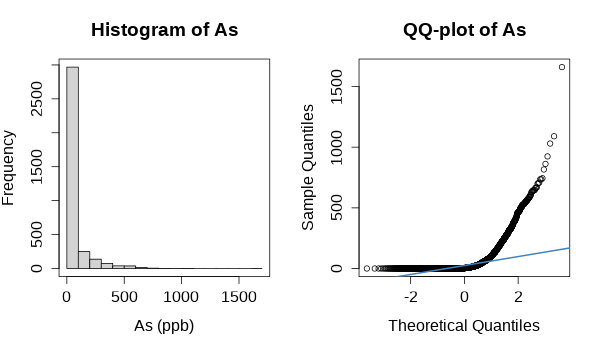

In [ ]:
%%R -w 600 -h 350 -u px
par(mfrow=c(1,2))
hist(mf$As, breaks=20, xlab = "As (ppb)", main="Histogram of As")
box()
qqnorm(mf$As, pch = 1,main= "QQ-plot of As")
qqline(mf$As, col = "steelblue", lwd = 2)

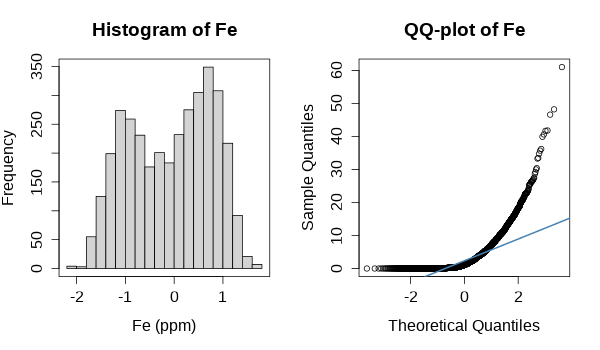

In [ ]:
%%R -w 600 -h 350 -u px
par(mfrow=c(1,2))
hist(log10(mf$Fe), breaks=20, xlab = "Fe (ppm)", main="Histogram of Fe")
box()
qqnorm(mf$Fe, pch = 1,main= "QQ-plot of Fe")
qqline(mf$Fe, col = "steelblue", lwd = 2)

#### Data Transformation

First, we have to calculate appropriate transformation parameters using the **powerTransform()** function of the car package and then use this parameter to transform the data using the **bcPower()** function.

In [ ]:
%%R
## As
power_As<-powerTransform(mf.na$As)
lambda_As<-power_As$lambda
mf.na$As.bc<-bcPower(mf.na$As,lambda_As)

In [ ]:
%%R
# Fe
power_Fe<-powerTransform(mf.na$Fe)
lambda_Fe<-power_Fe$lambda
mf.na$Fe.bc<-bcPower(mf.na$Fe,lambda_Fe)
glimpse(mf.na)

Rows: 3,509
Columns: 9
$ SAMPLE_ID  <chr> "S98_02701", "S98_02715", "S98_02979", "S98_02992", "S98_03…
$ LONG_DEG   <dbl> 90.0930, 89.4100, 91.6030, 91.1750, 89.5550, 89.4020, 89.46…
$ LAT_DEG    <dbl> 22.3720, 23.9420, 24.5720, 23.7910, 22.8110, 23.3010, 23.46…
$ WELL_TYPE  <chr> "DTW", "STW", "STW", "STW", "DTW", "STW", "STW", "DTW", "DT…
$ WELL_DEPTH <dbl> 322.0, 42.0, 38.0, 20.0, 310.0, 55.0, 53.0, 282.0, 332.0, 2…
$ As         <dbl> 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,…
$ Fe         <dbl> 0.103, 0.087, 1.370, 0.128, 0.019, 0.042, 0.036, 0.158, 0.0…
$ As.bc      <dbl> -0.7100121, -0.7100121, -0.7100121, -0.7100121, -0.7100121,…
$ Fe.bc      <dbl> -2.1356988, -2.2838459, 0.3175727, -1.9429567, -3.5582815, …


### Create a SPDF

In [ ]:
%%R
##  define coordinates
point.xy <- mf.na[,c(2,3)]
# Convert to spatial point
point.SPDF <- SpatialPointsDataFrame(coords = point.xy, data=mf.na)
# Define projection
proj4string(point.SPDF) = CRS("+proj=longlat +ellps=WGS84")  # WGS 84
# Change projection
BUTM<-proj4string(bd)                     # extract projection information
point.SPDF.PROJ<- spTransform(point.SPDF, # Input SPDF
                        BUTM)             # projection

In [ ]:
%%R
# convert to a data-frame
point.df<-as.data.frame(point.SPDF.PROJ)
# Rename (last two column)
colnames(point.df)[10] <- "x"
colnames(point.df)[11] <- "y"
head(point.df)

  SAMPLE_ID LONG_DEG LAT_DEG WELL_TYPE WELL_DEPTH  As    Fe      As.bc
1 S98_02701   90.093  22.372       DTW        322 0.5 0.103 -0.7100121
2 S98_02715   89.410  23.942       STW         42 0.5 0.087 -0.7100121
3 S98_02979   91.603  24.572       STW         38 0.5 1.370 -0.7100121
4 S98_02992   91.175  23.791       STW         20 0.5 0.128 -0.7100121
5 S98_03108   89.555  22.811       DTW        310 0.5 0.019 -0.7100121
6 S98_03167   89.402  23.301       STW         55 0.5 0.042 -0.7100121
       Fe.bc        x       y
1 -2.1356988 509574.3 2474006
2 -2.2838459 439962.9 2647931
3  0.3175727 662328.1 2718502
4 -1.9429567 619708.4 2631583
5 -3.5582815 454332.2 2522667
6 -2.9072566 438852.0 2576967


### Make Prediction Grid

In [ ]:
%%R
bbox(bd)

        min       max
x  298521.7  778071.3
y 2276992.7 2946935.1


In [ ]:
%%R
res <- 5000 # resolution
# round extremes to resolution
x.min <- bbox(bd)[1,1]%/%res*res
x.max <- (bbox(bd)[1,2]+res)%/%res*res # make sure it is outside the bbox

y.min <- bbox(bd)[2,1]%/%res*res
y.max <- (bbox(bd)[2,2]+res)%/%res*res

grid.mf <- expand.grid(x = seq(x.min, x.max, by=res),
              y = seq(y.min, y.max, by=res))
head(grid.mf)

       x       y
1 295000 2275000
2 300000 2275000
3 305000 2275000
4 310000 2275000
5 315000 2275000
6 320000 2275000


In [ ]:
%%R
##  define coordinates
grid.xy <- grid.mf[,c(1,2)]
# Convert to spatial point
grid.SPDF <- SpatialPointsDataFrame(coords = grid.xy, data=grid.mf)
# Define projection
proj4string(grid.SPDF) = CRS(proj4string(bd) )


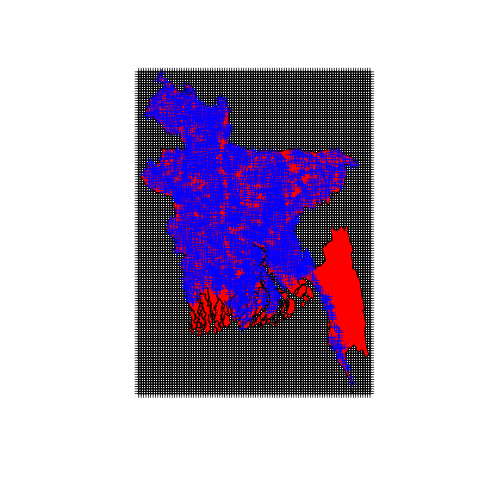

In [ ]:
%%R
plot(grid.SPDF)
plot(bd, add=TRUE, col="red")
plot(point.SPDF.PROJ, add=TRUE, col="blue")

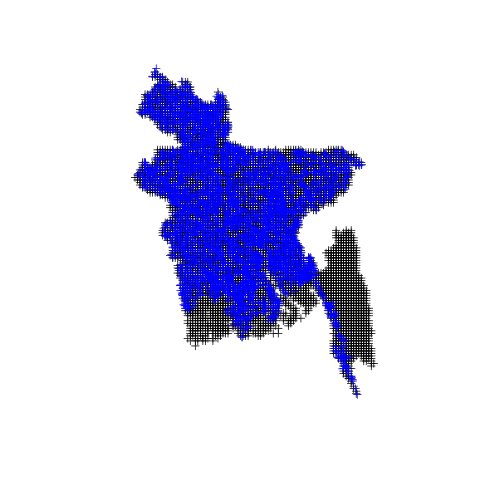

In [ ]:
%%R
grid.bd <-grid.SPDF[bd, ]
plot(grid.bd)
plot(point.SPDF.PROJ, add=TRUE, col="blue")

In [ ]:
%%R
# convert to a data-frame
grid.xy<-as.data.frame(grid.bd)
head(grid.xy)

          x       y    x.1     y.1
580  740000 2300000 740000 2300000
678  740000 2305000 740000 2305000
775  735000 2310000 735000 2310000
873  735000 2315000 735000 2315000
970  730000 2320000 730000 2320000
1068 730000 2325000 730000 2325000


### Define x & y variables to coordinates

In [ ]:
%%R
coordinates(point.df) = ~x+y
coordinates(grid.xy) = ~x+y

## **Ordinary Kriging**

### **Variogram Modeling**

Now, we will model an empirical variogram with two structural components: A range structure with a spherical model and long-range structure

In [ ]:
%%R
point.df <- point.df[-zerodist(point.df)[,1],]
# Short range structure
v<-variogram(As.bc~ 1, data =point.df, cloud=F)
m<-vgm(5,"Exp",40000,3)
m.f<-fit.variogram(v, m)
m.f

  model    psill    range
1   Nug 2.262043     0.00
2   Exp 3.109399 39504.05


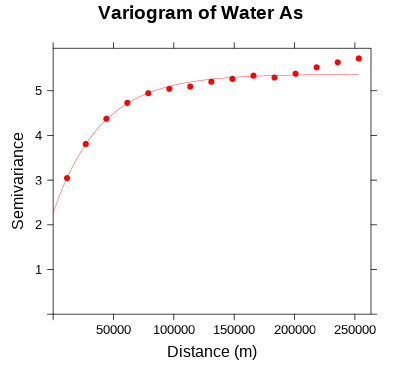

In [ ]:
%%R -w 400 -h 375 -u px
# Plot varigram and fitted model:
plot(v, pl=F,
     model=m.f,
     col="red",
     cex=0.9,
     lwd=0.5,
     lty=1,
     pch=19,
     main="Variogram of Water As",
     xlab="Distance (m)",
     ylab="Semivariance")


## **K-fold Cross Validation**


K-fold cross-validation is a widely used technique in machine learning and statistics to assess the performance and generalization of a predictive model. It involves dividing a dataset into K subsets or "folds," using K-1 folds for training and the remaining fold for testing. This process is repeated K times, with each fold serving as the test set once. K-fold cross-validation helps to provide a more reliable estimate of a model's performance and its ability to generalize to new, unseen data.

We will use **krige.cv()** to evaluate the model with k-fold cross validation.

In [ ]:
%%R
cv<-krige.cv(As.bc ~ 1,
         point.df,         # data
         model = m.f,
         nmax=100,         # fitted varigram model
         nfold=10)         # five-fold cross validation

  |======================================================================| 100%


In [ ]:
%%R
summary(cv)

Object of class SpatialPointsDataFrame
Coordinates:
        min       max
x  306178.9  751030.6
y 2298326.2 2946787.5
Is projected: NA 
proj4string : [NA]
Number of points: 3398
Data attributes:
   var1.pred          var1.var        observed         residual        
 Min.   :-1.4893   Min.   :2.498   Min.   :-1.455   Min.   :-6.108291  
 1st Qu.:-0.2041   1st Qu.:2.773   1st Qu.:-1.455   1st Qu.:-1.004198  
 Median : 1.2120   Median :2.836   Median : 1.275   Median : 0.000778  
 Mean   : 1.2729   Mean   :2.848   Mean   : 1.270   Mean   :-0.002494  
 3rd Qu.: 2.5511   3rd Qu.:2.904   3rd Qu.: 3.446   3rd Qu.: 1.050527  
 Max.   : 4.9182   Max.   :4.394   Max.   : 5.802   Max.   : 5.347521  
     zscore               fold       
 Min.   :-3.639683   Min.   : 1.000  
 1st Qu.:-0.592353   1st Qu.: 3.000  
 Median : 0.000455   Median : 5.000  
 Mean   :-0.001306   Mean   : 5.446  
 3rd Qu.: 0.622692   3rd Qu.: 8.000  
 Max.   : 3.150063   Max.   :10.000  


In [ ]:
%%R
# Root Mean Squre Error (RMSE)
RMSE<-round(sqrt(mean(cv$residual^2)),3)
RMSE



[1] 1.631


### Plot Observed vs CV Predicted values

`geom_smooth()` using formula = 'y ~ x'


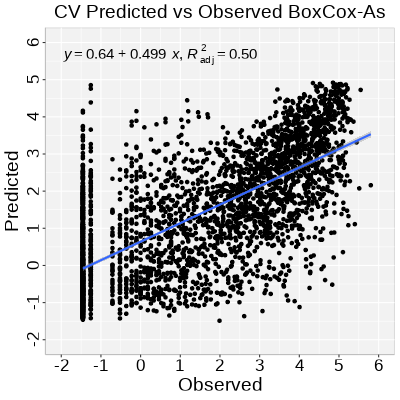

In [ ]:
%%R -w 400 -h 400 -u px

cv.df<-as.data.frame(cv)

formula<-y~x

ggplot(cv.df, aes(observed,var1.pred)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("CV Predicted vs Observed BoxCox-As") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(-2,6), breaks=seq(-2, 6, 1))+
  scale_y_continuous(limits=c(-2,6), breaks=seq(-2, 6, 1)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## **Ordinary Kriging**




In [ ]:
%%R
OK<-krige(As.bc~1,
              loc= point.df,        # Data frame
              newdata=grid.xy,      # Prediction grid
              model = m.f,          # fitted varigram model
              nmax =100)            # no of samples

[using ordinary kriging]


In [ ]:
%%R
summary(OK)

Object of class SpatialPointsDataFrame
Coordinates:
      min     max
x  300000  775000
y 2300000 2940000
Is projected: NA 
proj4string : [NA]
Number of points: 5614
Data attributes:
   var1.pred          var1.var    
 Min.   :-1.5455   Min.   :2.516  
 1st Qu.:-0.1015   1st Qu.:2.767  
 Median : 1.1838   Median :2.842  
 Mean   : 1.2289   Mean   :3.165  
 3rd Qu.: 2.3692   3rd Qu.:3.008  
 Max.   : 4.9087   Max.   :6.048  


### Back-transformation
We will back transformation using transformation parameters that have used Box-cos transformation

In [ ]:
%%R
k<-1/lambda_As
OK$OK.pred <-((OK$var1.pred *lambda_As +1)^k)
OK$OK.var <-((OK$var1.var *lambda_As +1)^k)
summary(OK)

Object of class SpatialPointsDataFrame
Coordinates:
      min     max
x  300000  775000
y 2300000 2940000
Is projected: NA 
proj4string : [NA]
Number of points: 5614
Data attributes:
   var1.pred          var1.var        OK.pred             OK.var       
 Min.   :-1.5455   Min.   :2.516   Min.   :  0.2303   Min.   :  15.86  
 1st Qu.:-0.1015   1st Qu.:2.767   1st Qu.:  0.9038   1st Qu.:  21.56  
 Median : 1.1838   Median :2.842   Median :  3.4384   Median :  23.65  
 Mean   : 1.2289   Mean   :3.165   Mean   : 18.7314   Mean   : 114.27  
 3rd Qu.: 2.3692   3rd Qu.:3.008   3rd Qu.: 13.2925   3rd Qu.:  29.14  
 Max.   : 4.9087   Max.   :6.048   Max.   :401.5080   Max.   :2519.02  


### Convert to Raster

In [ ]:
%%R
OK.pred<-rasterFromXYZ(as.data.frame(OK)[, c("x", "y", "OK.pred")])
OK.var<-rasterFromXYZ(as.data.frame(OK)[, c("x", "y", "OK.var")])

### Plot OK predicted As and Error

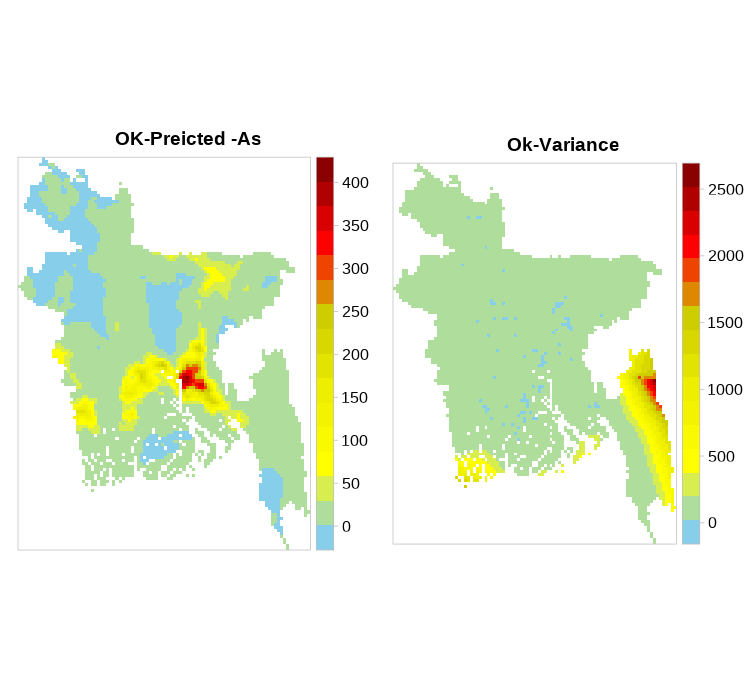

In [ ]:
%%R -w 750 -h 700 -u px
colr <-  colorRampPalette(c("sky blue","yellow","yellow2", "yellow3","red", "red4"), space = "rgb")
p.strip <- list(cex=1.25)
ckey <- list(labels=list(cex=1, rot=0), height=1)

p1<-levelplot(OK.pred,
             margin=FALSE,
             auto.key=FALSE,
             scales=list(y=list(draw=F,cex=.3,rot=90, tck= 0.35,alternating=1,col="grey"),
             x=list(draw=F, cex=.3,tck= .35)),
             par.settings=list(axis.line=list(col='grey')),
             col.regions=colr,
             colorkey=ckey,
             par.strip.text=p.strip,
             main="OK-Preicted -As")

p2<-levelplot(OK.var,
             margin=FALSE,
             auto.key=FALSE,
             scales=list(y=list(draw=F,cex=.3,rot=90, tck= 0.35,alternating=1,col="grey"),
             x=list(draw=F, cex=.3,tck= .35)),
             par.settings=list(axis.line=list(col='grey')),
             col.regions=colr,
             colorkey=ckey,
             par.strip.text=p.strip,
             main="Ok-Variance")

grid.arrange(p1, p2, nrow = 1)

## **Co-Kriging**

### Variogram of target and covariable

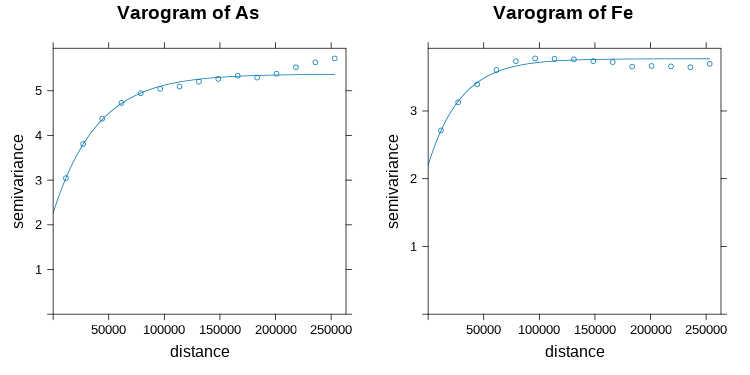

In [ ]:
%%R -w 750 -h 375 -u px
# target variable
v_as<-variogram(As.bc~ 1, data =point.df, cloud=F)
m_as<-vgm(5,"Exp",40000,3)
m.f_as<-fit.variogram(v_as, m_as)
p1<-plot(v_as, pl=F, model=m.f_as, main= "Varogram of As")
# co variable
v_fe<-variogram(Fe.bc~ 1, data =point.df, cloud=F)
m_fe<-vgm(5,"Exp",40000,3)
m.f_fe<-fit.variogram(v_fe, m_fe)
p2<-plot(v_fe, pl=F, model=m.f_fe, main= "Varogram of Fe")
grid.arrange(p1, p2, ncol = 2)  # Multiplot

### Cross-variogram

In [ ]:
%%R
g <- gstat(NULL, id = "As", form = As.bc ~ 1, data=point.df)
g <- gstat(g, id = "Fe", form = Fe.bc ~ 1, data=point.df)

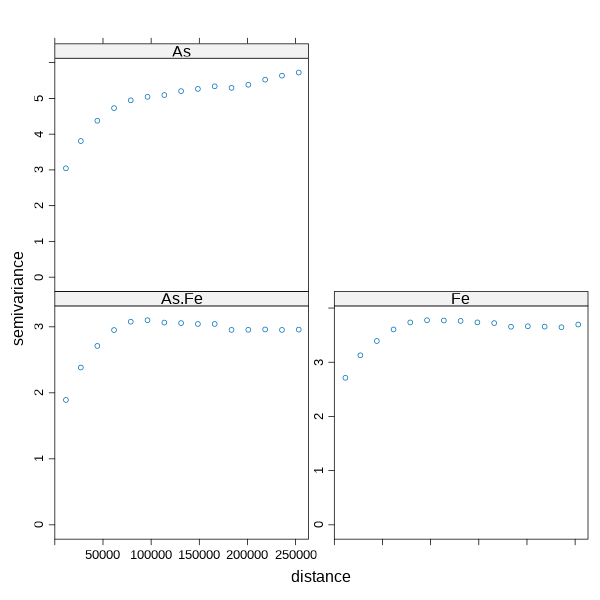

In [ ]:
%%R -w 600 -h 600 -u px
v.cross <- variogram(g)
plot(v.cross, pl=F)

### Fit variogram models

In [ ]:
%%R
g <- gstat(g, id = "As", model = m.f_as, fill.all=T)
g

data:
As : formula = As.bc`~`1 ; data dim = 3398 x 9
Fe : formula = Fe.bc`~`1 ; data dim = 3398 x 9
variograms:
         model    psill    range
As[1]      Nug 2.262043     0.00
As[2]      Exp 3.109399 39504.05
Fe[1]      Nug 2.262043     0.00
Fe[2]      Exp 3.109399 39504.05
As.Fe[1]   Nug 2.262043     0.00
As.Fe[2]   Exp 3.109399 39504.05


In [ ]:
%%R
g <- fit.lmc(v.cross, g,  fit.method=6, correct.diagonal=1.01)
g

data:
As : formula = As.bc`~`1 ; data dim = 3398 x 9
Fe : formula = Fe.bc`~`1 ; data dim = 3398 x 9
variograms:
         model    psill    range
As[1]      Nug 2.215158     0.00
As[2]      Exp 3.266758 39504.05
Fe[1]      Nug 2.520929     0.00
Fe[2]      Exp 1.276589 39504.05
As.Fe[1]   Nug 1.690548     0.00
As.Fe[2]   Exp 1.382944 39504.05


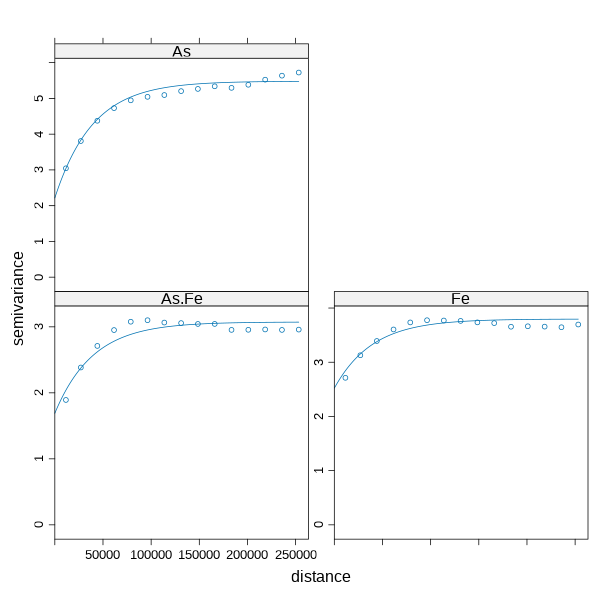

In [ ]:
%%R -w 600 -h 600 -u px
plot(variogram(g), model=g$model)

### CK Cross-validation

In [ ]:
%%R
cv.ck <- gstat.cv(g, nmax=100, nfold = 5)
summary(cv.ck)

  |                                                                      |   0%Linear Model of Coregionalization found. Good.
[using ordinary cokriging]
  |==================                                                    |  25%Linear Model of Coregionalization found. Good.
[using ordinary cokriging]
  |===================================                                   |  50%Linear Model of Coregionalization found. Good.
[using ordinary cokriging]
  |====================================================                  |  75%Linear Model of Coregionalization found. Good.
[using ordinary cokriging]
  |======================================================================| 100%Linear Model of Coregionalization found. Good.
[using ordinary cokriging]

Object of class SpatialPointsDataFrame
Coordinates:
        min       max
x  306178.9  751030.6
y 2298326.2 2946787.5
Is projected: NA 
proj4string : [NA]
Number of points: 3398
Data attributes:
    As.pred           As.var         ob

In [ ]:
%%R
RMSE<-sqrt(mean(cv.ck$residual^2))
RMSE

[1] 1.296725


### Co-Kriging prediction at grid locations

In [ ]:
%%R
CK <- predict(g, grid.xy, nmax=100)
summary(CK)

Linear Model of Coregionalization found. Good.
[using ordinary cokriging]
Object of class SpatialPointsDataFrame
Coordinates:
      min     max
x  300000  775000
y 2300000 2940000
Is projected: NA 
proj4string : [NA]
Number of points: 5614
Data attributes:
    As.pred            As.var         Fe.pred               Fe.var     
 Min.   :-1.6923   Min.   :2.468   Min.   :-2.3757484   Min.   :2.675  
 1st Qu.:-0.1314   1st Qu.:2.719   1st Qu.:-0.7570363   1st Qu.:2.800  
 Median : 1.0549   Median :2.796   Median : 0.1819377   Median :2.833  
 Mean   : 1.1880   Mean   :3.109   Mean   :-0.0007356   Mean   :2.948  
 3rd Qu.: 2.3430   3rd Qu.:2.970   3rd Qu.: 0.7651376   3rd Qu.:2.910  
 Max.   : 4.9964   Max.   :5.503   Max.   : 2.2233794   Max.   :3.810  
   cov.As.Fe    
 Min.   :1.823  
 1st Qu.:1.941  
 Median :1.976  
 Mean   :2.104  
 3rd Qu.:2.052  
 Max.   :3.084  


In [ ]:
%%R
# Back transformation
k<-1/lambda_As
CK$CK.pred <-((CK$As.pred *lambda_As+1)^k)
CK$CK.var <-((CK$As.var *lambda_As+1)^k)

In [ ]:
%%R
CK.pred<-rasterFromXYZ(as.data.frame(CK)[, c("x", "y", "CK.pred")])
CK.var<-rasterFromXYZ(as.data.frame(CK)[, c("x", "y", "CK.var")])

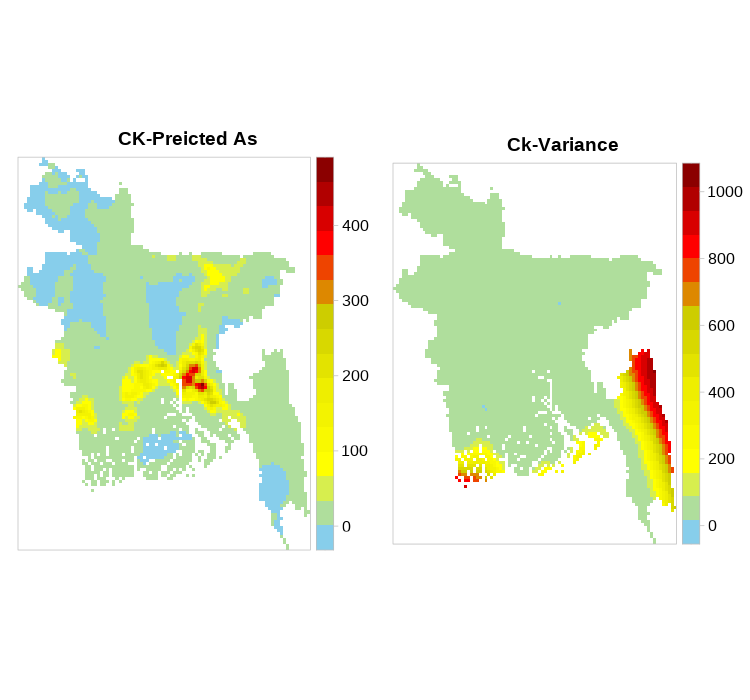

In [ ]:
%%R -w 750 -h 700 -u px
colr <-  colorRampPalette(c("sky blue","yellow","yellow2", "yellow3","red", "red4"), space = "rgb")
p.strip <- list(cex=1.25)
ckey <- list(labels=list(cex=1, rot=0), height=1)

p3<-levelplot(CK.pred,
             margin=FALSE,
             auto.key=FALSE,
             scales=list(y=list(draw=F,cex=.3,rot=90, tck= 0.35,alternating=1,col="grey"),
             x=list(draw=F, cex=.3,tck= .35)),
             par.settings=list(axis.line=list(col='grey')),
             col.regions=colr,
             colorkey=ckey,
             par.strip.text=p.strip,
             main="CK-Preicted As")

p4<-levelplot(CK.var,
             margin=FALSE,
             auto.key=FALSE,
             scales=list(y=list(draw=F,cex=.3,rot=90, tck= 0.35,alternating=1,col="grey"),
             x=list(draw=F, cex=.3,tck= .35)),
             par.settings=list(axis.line=list(col='grey')),
             col.regions=colr,
             colorkey=ckey,
             par.strip.text=p.strip,
             main="Ck-Variance")

grid.arrange(p3, p4, nrow = 1)

## **Indicator Kriging**

Indicator kriging (IK) is specifically designed for situations where the variable being analyzed is binary or categorical, such as the presence or absence of a certain geological feature, the occurrence of a disease, or the classification of land use types. It is a non-parametric geostatistical method that works with variables after indicator transformation (0, 1) of pre-defined threshold values or presence or absence and map the probability of exceeding these threshold values or binary map.

This is directly useful for probabilistic decision-making. It can also be used to estimate an entire cumulative probability distribution (CDF) and the mean (E-type-estimate) of CDF can be used as an estimate of the pollutant concentration after modeling of the upper and lower tails of the distribution (Goovaerts, 2009). The CDF based IK is applicable when data is strongly skewed, traditional data transformation limit to get robust statistics and estimators due to extreme values at sampled locations, assuming a constant mean and stationary variance.

Indicator kriging is specifically designed for situations where the variable being analyzed is binary or categorical, such as the presence or absence of a certain geological feature, the occurrence of a disease, or the classification of land use types.

We can use the **gstat** package in R to implement indicator kriging in probabilistic mapping, but no R package is available yet for e-type-estimating from CDFs of IK. **Gslib** and **SgeMS** are the most widely used geostatistical programs. **AUTO-IK** is an automatic Gslib routine for selecting threshold valuesCDF-basedry coding continuousCDF-basedlculation and modeling indicator semivariogram, modeling of the probability distribution at unmonitored location (regular or irregular grid), and estimation of mean and variance of those distributions.

### **Indicator transformation**

Indicator transformation, often referred to as indicator variable or dummy variable transformation.  Each indicator variable is binary, taking on values of 0 or 1. It has a value of 1 if the observation belongs to the category represented by that indicator variable, and 0 otherwise. This binary encoding effectively "flags" the presence or absence of a specific category.

Like in traditional kriging, you calculate a variogram, also known as a semivariogram, for the categorical data or binary variables. The variogram quantifies how the probability of being in a specific category changes with distance and direction. It measures the spatial dependence or variability of the binary/categorical variable.

Kriging Estimation: Using the variogram, you can then predict the probability or indicator value at unmeasured locations within your study area. Instead of estimating a continuous variable, Indicator Kriging estimates the probability of an event (e.g., presence) occurring at each location. These probability estimates can range from 0 to 1, representing the likelihood of being in a specific category.

In [ ]:
%%R
point.df<-as.data.frame(point.df)
ik.10<-point.df$As > 10    # threshold 10 ppb
ik.50<-point.df$As > 50    # threshold 50 ppb

In [ ]:
%%R
ik.df<-cbind(point.df,ik.10,ik.50)
glimpse(ik.df)

Rows: 3,398
Columns: 13
$ SAMPLE_ID  <chr> "S98_02701", "S98_02715", "S98_02979", "S98_02992", "S98_03…
$ LONG_DEG   <dbl> 90.0930, 89.4100, 91.6030, 91.1750, 89.5550, 89.4020, 89.46…
$ LAT_DEG    <dbl> 22.3720, 23.9420, 24.5720, 23.7910, 22.8110, 23.3010, 23.46…
$ WELL_TYPE  <chr> "DTW", "STW", "STW", "STW", "DTW", "STW", "STW", "DTW", "DT…
$ WELL_DEPTH <dbl> 322.0, 42.0, 38.0, 20.0, 310.0, 55.0, 53.0, 282.0, 332.0, 2…
$ As         <dbl> 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,…
$ Fe         <dbl> 0.103, 0.087, 1.370, 0.128, 0.019, 0.042, 0.036, 0.158, 0.0…
$ As.bc      <dbl> -0.7100121, -0.7100121, -0.7100121, -0.7100121, -0.7100121,…
$ Fe.bc      <dbl> -2.1356988, -2.2838459, 0.3175727, -1.9429567, -3.5582815, …
$ x          <dbl> 509574.3, 439962.9, 662328.1, 619708.4, 454332.2, 438852.0,…
$ y          <dbl> 2474006, 2647931, 2718502, 2631583, 2522667, 2576967, 25947…
$ ik.10      <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…
$ ik.50      <lg

In [ ]:
%%R
coordinates(ik.df)=~x+y

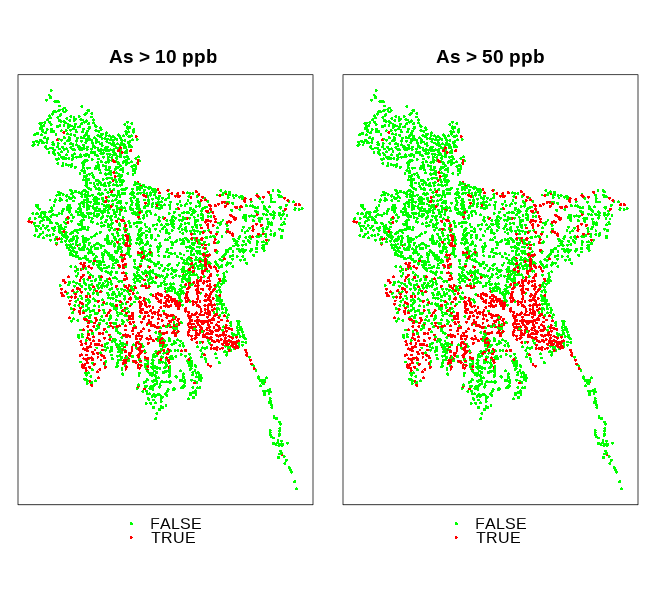

In [ ]:
%%R -w 650 -h 600 -u px
p1<-spplot(ik.df, zcol = "ik.50", col.regions = c("green", "red"), cex=.5,
       main = "As > 10 ppb")
p2<-spplot(ik.df, zcol = "ik.50", col.regions = c("green", "red"), cex=.5,
       main = " As > 50 ppb")
grid.arrange(p1, p2, ncol=2)


### Create indicator variograms

In [ ]:
%%R
#ik.df <- ik.df[-zerodist(ik.df)[,1],]
# Variogram
v10<-variogram(ik.10~ 1, data = ik.df)
v50<-variogram(ik.50~ 1, data = ik.df)
# Intial parameter set by eye esitmation
m10<-vgm(0.15,"Exp",40000,0.05)
m50<-vgm(0.15,"Exp",40000,0.05)
# least square fit
m.f.10<-fit.variogram(v10, m10)
m.f.50<-fit.variogram(v50, m50)
m.f.10

  model     psill    range
1   Nug 0.1337839     0.00
2   Exp 0.1164496 46535.32


### Plot varigram and fitted model

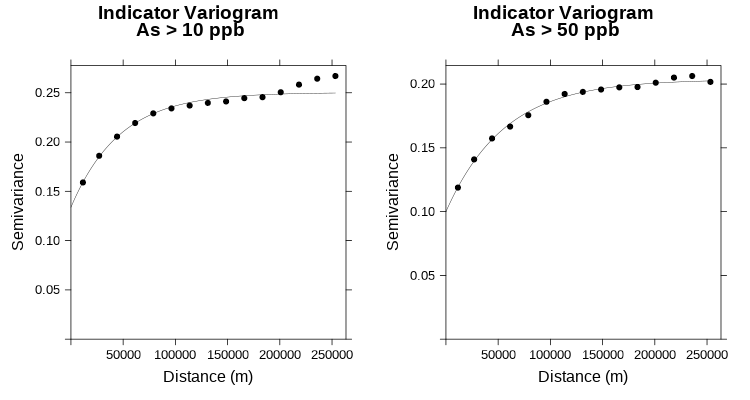

In [ ]:
%%R -w 750 -h 400 -u px
#### Plot varigram and fitted model:
v1<-plot(v10, pl=F,
     model=m.f.10,
     col="black",
     cex=0.9,
     lwd=0.5,
     lty=1,
     pch=19,
     main="Indicator Variogram\n As > 10 ppb",
     xlab="Distance (m)",
     ylab="Semivariance")

v2<-plot(v50, pl=F,
     model=m.f.50,
     col="black",
     cex=0.9,
     lwd=0.5,
     lty=1,
     pch=19,
     main="Indicator Variogram\n As > 50 ppb",
     xlab="Distance (m)",
     ylab="Semivariance")
grid.arrange(v1, v2, nrow = 1)

### Cross validation
We will compute the Leave-one-out cross-validation (LOOCV) of the IK prediction of As concentration greater than 10 and 5 ppb. It works the same as for parametric kriging: hold one point out, predict its probability of a TRUE indicator from the other points, and then compare this probability with the actual value of the indicator.

In [ ]:
%%R
cv.10 <- krige.cv(ik.10 ~ 1, loc = ik.df, model = m.f.10, nfold=5)
cv.50 <- krige.cv(ik.50 ~ 1, loc = ik.df, model = m.f.50, nfold=5)

  |======================================================================| 100%
  |======================================================================| 100%


### Limit the predicted probabilities to the range:

In [ ]:
%%R
cv.10$var1.pred <- pmin(1, cv.10$var1.pred)
cv.10$var1.pred <- pmax(0, cv.10$var1.pred)

cv.50$var1.pred <- pmin(1, cv.50$var1.pred)
cv.50$var1.pred <- pmax(0, cv.50$var1.pred)
summary(cv.50)

In [ ]:
%%R
summary(cv.50)

Object of class SpatialPointsDataFrame
Coordinates:
        min       max
x  306178.9  751030.6
y 2298326.2 2946787.5
Is projected: NA 
proj4string : [NA]
Number of points: 3398
Data attributes:
   var1.pred           var1.var       observed          residual         
 Min.   :-0.03722   Min.   :0.1077   Mode :logical   Min.   :-0.9679323  
 1st Qu.: 0.02627   1st Qu.:0.1152   FALSE:2541      1st Qu.:-0.1555157  
 Median : 0.14239   Median :0.1169   TRUE :857       Median :-0.0265283  
 Mean   : 0.25150   Mean   :0.1174                   Mean   : 0.0007039  
 3rd Qu.: 0.39986   3rd Qu.:0.1188                   3rd Qu.: 0.0120200  
 Max.   : 1.01575   Max.   :0.1626                   Max.   : 1.0058131  
     zscore               fold     
 Min.   :-2.858094   Min.   :1.00  
 1st Qu.:-0.458324   1st Qu.:2.00  
 Median :-0.076970   Median :3.00  
 Mean   : 0.001984   Mean   :2.99  
 3rd Qu.: 0.034805   3rd Qu.:4.00  
 Max.   : 2.982423   Max.   :5.00  


Now we will make post-plots of the predicted probabilities, with the symbol size proportional to the probability, with the points colored red for a FALSE indicator and green for a TRUE indicator

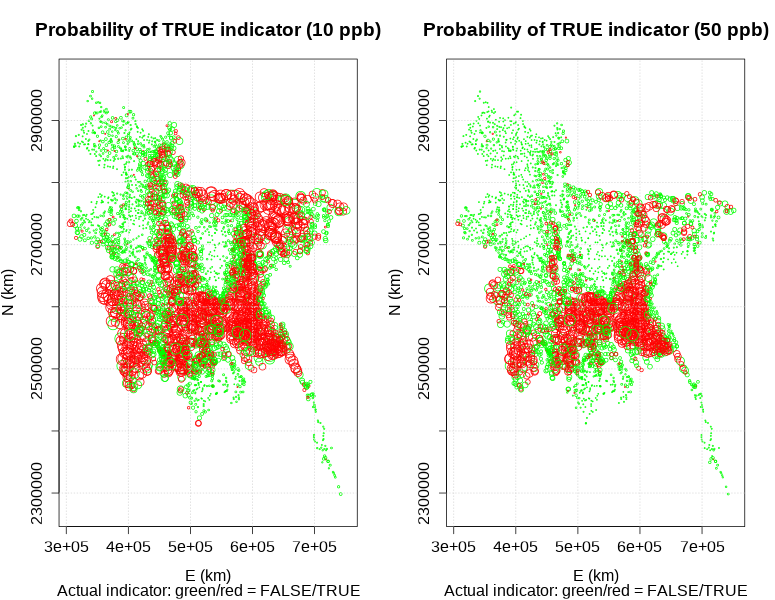

In [ ]:
%%R -w 775 -h 600 -u px
par(mfrow=c(1,2))
plot(coordinates(cv.10), asp = 1, pch=21, col = ifelse(cv.10$observed,
 "red", "green"), cex = 0.2 + 1 * cv.10$var1.pred,
 xlab = "E (km)", ylab = "N (km)", main = "Probability of TRUE indicator (10 ppb)",
 sub = "Actual indicator: green/red = FALSE/TRUE")
 grid()

plot(coordinates(cv.50), asp = 1, pch=21, col = ifelse(cv.50$observed,
 "red", "green"), cex = 0.2 + 1 * cv.50$var1.pred,
 xlab = "E (km)", ylab = "N (km)", main = "Probability of TRUE indicator (50 ppb)",
 sub = "Actual indicator: green/red = FALSE/TRUE")
 grid()

### IK Prediction at grid location

In [ ]:
%%R
ik.grid.10<-krige(ik.10~ 1,
                  nmax=50,
                  loc=ik.df,        # Data frame
                  newdata=grid.xy,     # Prediction location
                  model = m.f.10)   # fitted varigram model

[using ordinary kriging]


In [ ]:
%%R
ik.grid.50.sim<-krige(ik.50~ 1, nmax=50,
              loc=ik.df,  # Data frame
             newdata=grid.xy,     # Prediction location
              model = m.f.50)   # fitted varigram model

drawing 4 GLS realisations of beta...
[using conditional Gaussian simulation]


In [ ]:
%%R
summary(ik.grid.50.sim)

In [ ]:
%%R
ik.grid.10$var1.pred <- pmin(1, ik.grid.10$var1.pred)
ik.grid.10$var1.pred <- pmax(0, ik.grid.10$var1.pred)

ik.grid.50$var1.pred <- pmin(1, ik.grid.50$var1.pred)
ik.grid.50$var1.pred <- pmax(0, ik.grid.50$var1.pred)
summary(ik.grid.50)

Object of class SpatialPointsDataFrame
Coordinates:
      min     max
x  300000  775000
y 2300000 2940000
Is projected: NA 
proj4string : [NA]
Number of points: 5614
Data attributes:
   var1.pred          var1.var     
 Min.   :0.00000   Min.   :0.1077  
 1st Qu.:0.01885   1st Qu.:0.1146  
 Median :0.13756   Median :0.1165  
 Mean   :0.23136   Mean   :0.1262  
 3rd Qu.:0.34960   3rd Qu.:0.1209  
 Max.   :1.00000   Max.   :0.2329  


In [ ]:
%%R
p10<-rasterFromXYZ(as.data.frame(ik.grid.10)[, c("x", "y", "var1.pred")])
p50<-rasterFromXYZ(as.data.frame(ik.grid.50)[, c("x", "y", "var1.pred")])

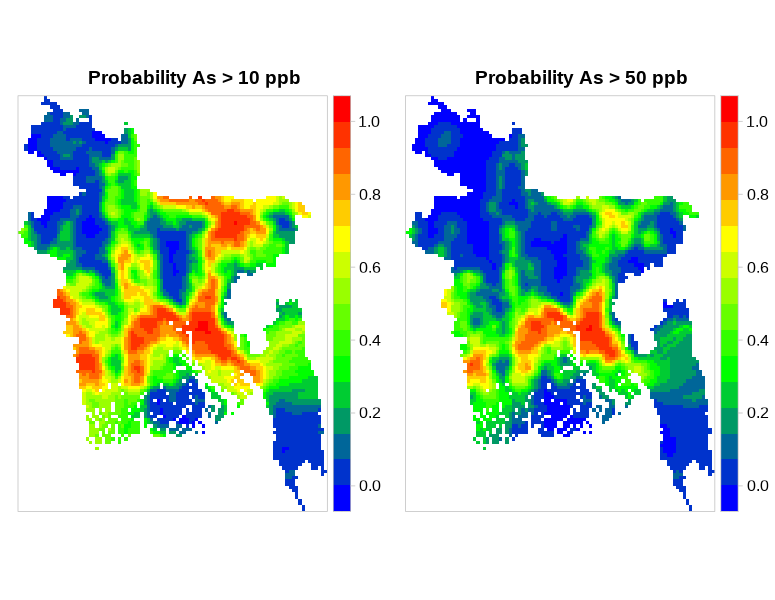

In [ ]:
%%R -w 775 -h 600 -u px
colr <-  colorRampPalette(c("blue","green",'yellow',"red"), space = "rgb")
p.strip <- list(cex=1.25)
ckey <- list(labels=list(cex=1, rot=0), height=1)

ik.plot.10<-levelplot(p10,
             margin=FALSE,
             auto.key=FALSE,
             scales=list(y=list(draw=F,cex=.3,rot=90, tck= 0.35,alternating=1,col="grey"),
             x=list(draw=F, cex=.3,tck= .35)),
             par.settings=list(axis.line=list(col='grey')),
             col.regions=colr,
             colorkey=ckey,
             par.strip.text=p.strip,
             main="Probability As > 10 ppb")

ik.plot.50<-levelplot(p50,
             margin=FALSE,
             auto.key=FALSE,
             scales=list(y=list(draw=F,cex=.3,rot=90, tck= 0.35,alternating=1,col="grey"),
             x=list(draw=F, cex=.3,tck= .35)),
             par.settings=list(axis.line=list(col='grey')),
             col.regions=colr,
             colorkey=ckey,
             par.strip.text=p.strip,
             main="Probability As > 50 ppb")

grid.arrange(ik.plot.10, ik.plot.50, nrow = 1)

### Further Reading

1. [Understanding indicator kriging](https://pro.arcgis.com/en/pro-app/latest/help/analysis/geostatistical-analyst/understanding-indicator-kriging.htm)

2. [An Overview of Multiple Indicator Kriging](https://geostatisticslessons.com/lessons/mikoverview)
